<a href="https://colab.research.google.com/github/nasim-fani/RGB-rooftype-classification/blob/main/RGB_rooftype_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from numpy import array

In [ ]:
from keras.layers import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *

In [ ]:
Flat_Roof = Path('D:\Python\Lidar\RoofImage\Flat')
Gable_Roof = Path('D:\\Python\\Lidar\\RoofImage//Gable')
Hip_Roof = Path('D:\\Python\\Lidar\\RoofImage//Hip')

In [ ]:
maskDF = pd.DataFrame()

In [ ]:
for subject in tqdm(list(Flat_Roof.iterdir()), desc='Flat roof'):
    image = cv2.imread(str(subject))
    maskDF = maskDF.append({
        'image': image,
        'index1': int(0)
    }, ignore_index=True)

for subject in tqdm(list(Gable_Roof.iterdir()), desc='Gable roof'):
    image = cv2.imread(str(subject))
    maskDF = maskDF.append({
        'image': image,
        'index1': int(1)
    }, ignore_index=True)

for subject in tqdm(list(Hip_Roof.iterdir()), desc='Hip roof'):
    image = cv2.imread(str(subject))
    maskDF = maskDF.append({
        'image': image,
        'index1':int(2)
    }, ignore_index=True)

Hip roof: 100%|███████████████████████████████████████████████████████████████████| 4800/4800 [00:12<00:00, 371.17it/s]


In [ ]:
import pickle
with open('maskDF.pickle', 'wb') as f:
    pickle.dump(maskDF,f)

In [ ]:
maskDF

,image,index1
0,"[[[47, 50, 81], [47, 50, 81], [47, 50, 81], [4...",0.0
1,"[[[110, 111, 115], [111, 111, 115], [113, 112,...",0.0
2,"[[[42, 43, 54], [42, 43, 54], [42, 43, 55], [4...",0.0
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0.0
4,"[[[45, 45, 82], [51, 51, 91], [60, 60, 105], [...",0.0
...,...,...
14395,"[[[56, 54, 50], [56, 54, 50], [58, 56, 53], [6...",2.0
14396,"[[[41, 41, 81], [41, 41, 81], [42, 41, 83], [4...",2.0
14397,"[[[42, 41, 89], [42, 41, 89], [41, 39, 91], [4...",2.0
14398,"[[[90, 98, 124], [90, 98, 124], [90, 98, 122],...",2.0


In [ ]:
data = maskDF.iloc[:,0]
label = maskDF.iloc[:,1]

In [ ]:
label = label.astype('uint8')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
train_dataset = pd.DataFrame(X_train, columns = ['image', 'label'])
train_dataset.loc[:,'label']  = y_train

In [ ]:
x_train=[]
for i in X_train:
    x_train.append(i)
x_train = array(x_train)
y_train = array(y_train)

In [ ]:
x_val=[]
for i in X_val:
    x_val.append(i)
x_val = array(x_val)
y_val = array(y_val)

In [ ]:
x_test=[]
for i in X_test:
    x_test.append(i)
x_test = array(x_test)
y_test = array(y_test)

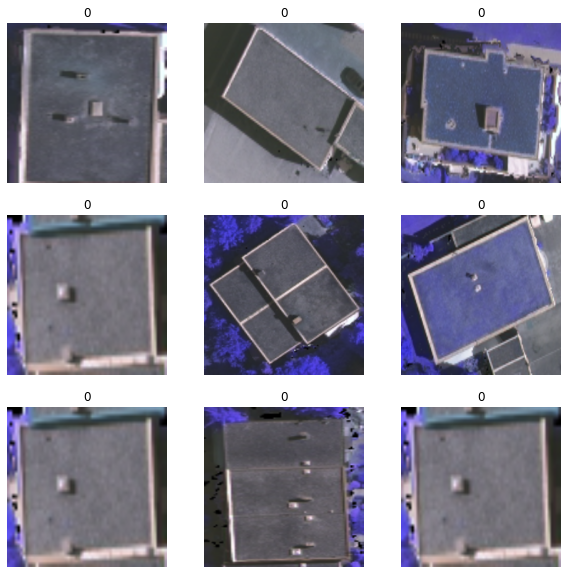

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[i].astype("uint8"))
    plt.title(label[i])
    plt.axis("off")

In [ ]:
# rescaling
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
IMG_SIZE = (224, 224)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(200)(x)
x = Dropout(0.3)(x) 
outputs = Dense(3)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               256200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0   

In [ ]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(lr = base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(x_val, y_val)

90/90 [==============================] - 30s 315ms/step - loss: 0.8780 - accuracy: 0.3260


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.88
initial accuracy: 0.34


In [ ]:
history = model.fit(x_train, y_train,
                    epochs=initial_epochs,
                    batch_size = 50,
                    validation_data=(x_val, y_val))

Epoch 1/10
173/173 [==============================] - 114s 648ms/step - loss: 0.1203 - accuracy: 0.9435 - val_loss: 0.0273 - val_accuracy: 0.9937
Epoch 2/10
173/173 [==============================] - 111s 641ms/step - loss: 0.0236 - accuracy: 0.9968 - val_loss: 0.0138 - val_accuracy: 0.9976
Epoch 3/10
173/173 [==============================] - 111s 641ms/step - loss: 0.0106 - accuracy: 0.9988 - val_loss: 0.0059 - val_accuracy: 0.9990
Epoch 4/10
173/173 [==============================] - 112s 648ms/step - loss: 0.0059 - accuracy: 0.9995 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 5/10
173/173 [==============================] - 111s 642ms/step - loss: 0.0042 - accuracy: 0.9999 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/10
173/173 [==============================] - 111s 645ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/10
173/173 [==============================] - 112s 649ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0018 -

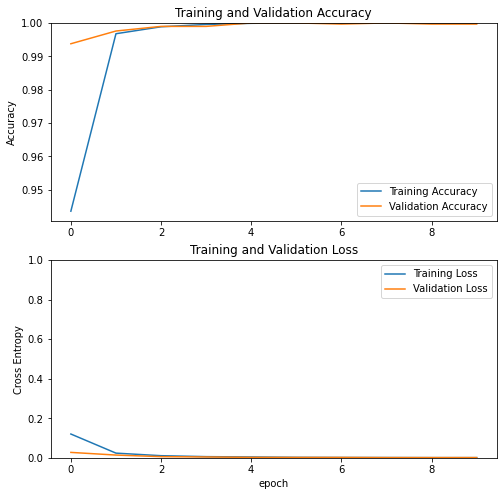

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test,y_test)
print('Test accuracy :', accuracy)

90/90 [==============================] - 28s 316ms/step - loss: 0.0018 - accuracy: 0.9993
Test accuracy : 0.9993055462837219


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
prediction = model.predict(x_test)

In [ ]:
prediction = np.argmax(prediction, axis = 1)
prediction

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [ ]:
y_test = np.argmax(y_test, axis = 1)
y_test

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       978
           1       1.00      1.00      1.00       946
           2       1.00      1.00      1.00       956

    accuracy                           1.00      2880
   macro avg       1.00      1.00      1.00      2880
weighted avg       1.00      1.00      1.00      2880



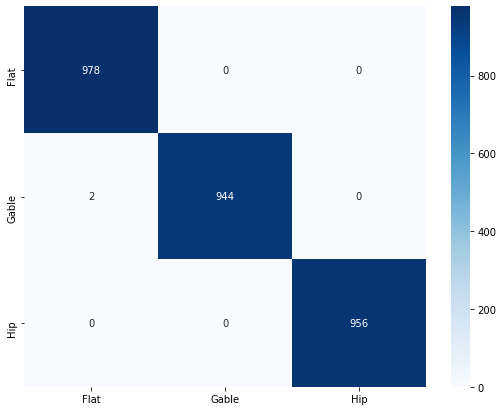

In [ ]:
from sklearn.metrics import confusion_matrix ,classification_report
import seaborn as sns 
c = confusion_matrix(y_test , prediction)
names = ['Flat', 'Gable', 'Hip']
plt.figure(figsize = (9,7))
sns.heatmap(c,cmap='Blues',fmt='d',annot=True, xticklabels = names, yticklabels = names)
print(classification_report(y_test,prediction))
